<a href="https://colab.research.google.com/github/dennistay1981/Resources/blob/main/Miscellaneous/VAE_CLUSTER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-docx
!pip install contractions

# Import Libraries
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import numpy as np
import string
import re
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
from docx import Document
import pandas as pd
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from transformers import BertTokenizer, BertModel
import torch
import contractions
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.decomposition import PCA
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle

In [ ]:
def extract_text_from_docx(file_path):
    doc = Document(file_path)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return '\n'.join(full_text)

# Base directory
base_dir = r'C:\Users\cynth\OneDrive - Nanyang Technological University\nlp\OneDrive_2025-02-18'

# List of subdirectories to process
subdirs = [
    r'VAE WRITING STYLE\asgm 1 simulation',
    r'VAE WRITING STYLE\asgm 2 simulation',
    r'VAE WRITING STYLE\asgm 3 simulation',
    r'VAE WRITING STYLE\task 6 simulation',
    r'Practice - Singapore GE',
    r'Simulation'
]

# Process all documents
essays = []
for subdir in subdirs:
    full_path = os.path.join(base_dir, subdir)
    for file in os.listdir(full_path):
        if file.endswith('.docx') and not file.startswith('~$'):
            try:
                file_path = os.path.join(full_path, file)
                text = extract_text_from_docx(file_path)
                essays.append({'filename': file, 'text': text})
            except Exception as e:
                print(f"Error processing {file}: {e}")

# Create DataFrame
essays_df = pd.DataFrame(essays)



"""
IF ALL FILES ARE IN ONE DIRECTORY
"""
def extract_text_from_docx(file_path):
    doc = Document(file_path)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return '\n'.join(full_text)

# Base directory (containing all .docx files)
base_dir = r'C:\Users\cynth\OneDrive - Nanyang Technological University\nlp\OneDrive_2025-02-18\all_essays'

# Process all documents
essays = []
for file in os.listdir(base_dir):
    if file.endswith('.docx') and not file.startswith('~$'):
        try:
            file_path = os.path.join(base_dir, file)
            text = extract_text_from_docx(file_path)
            essays.append({'filename': file, 'text': text})
        except Exception as e:
            print(f"Error processing {file}: {e}")

# Create DataFrame
essays_df = pd.DataFrame(essays)

Data Preprocessing

In [ ]:
# Function for comprehensive text preprocessing
def preprocess_text(text):

    # handle possessives
    text = re.sub(r"'s\b", "", text)

    # Convert to lowercase
    text = text.lower()

    # Expand contractions
    text = contractions.fix(text)

    # Directly remove apostrophes
    text = text.replace("’", "")

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove whitespace
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)

    # Remove tabs
    text = re.sub(r'\t', ' ', text)   # Remove actual tab

    # Return the text
    return text

In [ ]:
# Apply preprocessing to the text column
essays_df['corrected_text'] = essays_df['text'].apply(preprocess_text)

In [ ]:
# Word Tokenization
essays_df['word_tokens'] = essays_df['corrected_text'].apply(lambda x:word_tokenize(x))
essays_df['word_count'] = essays_df['word_tokens'].apply(lambda x: len(x))
print('\nUnique word count: ')
print(essays_df['word_count'].unique())

In [ ]:
# Stop-word removal (skip punctuation check)
stop_words = set(stopwords.words('english'))

def categorize_tokens(tokens):
    filtered_tokens = []
    stopwords_found = []

    for token in tokens:
        if token in stop_words and token not in stopwords_found:
            stopwords_found.append(token)
        elif token not in stop_words:
            filtered_tokens.append(token)

    return filtered_tokens, len(filtered_tokens), stopwords_found

In [ ]:
# Apply to the word tokens column
essays_df[['filtered_tokens', 'tokens_count', 'stopwords_found']] = pd.DataFrame(essays_df['word_tokens'].apply(categorize_tokens).tolist(), index = essays_df.index)

In [ ]:
# Lemmatization with POS tagging
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

# Apply lemmatization safely
def lemmatize_token_list(token_list):
    return [lemmatizer.lemmatize(str(token), get_wordnet_pos(str(token)))
            for token in token_list if token]  # Added check for empty tokens

essays_df['lemmatized_tokens'] = essays_df['filtered_tokens'].apply(lemmatize_token_list)

In [ ]:
essays_df

TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
essays_df['lemmatized_text'] = essays_df['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))

tfidf_vectors = tfidf_vectorizer.fit_transform(essays_df['lemmatized_text'])

WORD2VEC

In [ ]:
import gensim.downloader as api
import numpy as np

# Load pre-trained model
word2vec_model = api.load('word2vec-google-news-300')

def get_document_embedding(text, model):
    # Tokenize text
    words = text.lower().split()
    # Filter words in vocabulary and get their vectors
    word_vectors = [model[word] for word in words if word in model]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    # Average the word vectors
    return np.mean(word_vectors, axis=0)

# Get embeddings for all essays
word2vec_vectors = [get_document_embedding(essay, word2vec_model) for essay in essays_df['lemmatized_text']]

SBERT

In [ ]:
from sentence_transformers import SentenceTransformer

# Load model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Create embeddings
sbert_vectors = sbert_model.encode(essays_df['text'])

BERT

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text, max_length=512, max_chunks=5):
    # Tokenize and truncate
    tokens = tokenizer(text, padding='max_length', truncation=True,
                       max_length=max_length, return_tensors='pt')

    # Get BERT embeddings
    with torch.no_grad():
        outputs = bert(**tokens)

    # Use CLS token embedding (sentence representation)
    return outputs.pooler_output[0].numpy()

# Process each essay
embeddings = []

for i, essay in enumerate(essays_df['text']):
    # Tokenize the essay
    encoding = tokenizer(
        essay,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    # Get BERT embeddings
    with torch.no_grad():
        outputs = bert(input_ids=encoding['input_ids'],
                      attention_mask=encoding['attention_mask'])
        # Use the [CLS] token as essay representation
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()

    embeddings.append(cls_embedding[0])

    if (i + 1) % 50 == 0:
        print(f"Processed {i + 1}/{len(essays_df)} essays")

bert_embedding = embeddings

TF-IDF + SBERT Hybrid

In [ ]:
from scipy.sparse import hstack
import numpy as np

# Normalize TF-IDF vectors
from sklearn.preprocessing import normalize
tfidf_normalized = normalize(tfidf_vectors)

# Convert to dense array for combination
tfidf_dense = tfidf_normalized.toarray()

# Normalize SBERT vectors (already dense)
sbert_normalized = normalize(sbert_vectors)

# Combine
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=384)
tfidf_reduced = svd.fit_transform(tfidf_vectors)
tfidf_reduced_norm = normalize(tfidf_reduced)

hybrid_tfsb_vectors = 0.3 * tfidf_reduced_norm + 0.7 * sbert_normalized

TF-IDF + WORD2VEC Hybrid

In [ ]:
tfidf_reduced_norm = normalize(svd.fit_transform(tfidf_vectors))
word2vec_normalized = normalize(np.array(word2vec_vectors))

# Make sure dimensions match
svd = TruncatedSVD(n_components=300)  # Set to match Word2Vec dimensions
tfidf_reduced = svd.fit_transform(tfidf_vectors)
tfidf_reduced_norm = normalize(tfidf_reduced)

# Combine
hybrid_tfw2v_vectors = 0.4 * tfidf_reduced_norm + 0.6 * word2vec_normalized

WORD2VEC + SBERT

In [ ]:
# Get dimensions
word2vec_dim = word2vec_normalized.shape[1]
sbert_dim = sbert_vectors.shape[1]

# Reduce SBERT dimension to match Word2Vec
print(f"Reducing SBERT dimension from {sbert_dim} to {word2vec_dim}")
svd = TruncatedSVD(n_components=word2vec_dim)
sbert_reduced = svd.fit_transform(sbert_normalized)
sbert_reduced_norm = normalize(sbert_reduced)

# Create hybrid embedding (30% Word2Vec, 70% SBERT)
hybrid_w2vsb_vectors = 0.3 * word2vec_normalized + 0.7 * sbert_reduced_norm

Reducing SBERT dimension from 384 to 300


CHINESE EMBEDDINGS

In [ ]:
import jieba
import numpy as np
from transformers import BertTokenizer, BertModel


def preprocess_chinese(text):
    """Preprocess Chinese text for word embeddings"""
    # Check for empty or non-string input
    if not isinstance(text, str) or not text.strip():
        return []

    # Remove punctuation
    text = re.sub(r'[^\w\s\u4e00-\u9fff]', '', text)

    # Segment Chinese text into words using jieba
    words = list(jieba.cut(text))

    # Remove stopwords
    stopwords = {'的', '了', '和', '是', '就', '都', '而', '及', '与', '着',
                '或', '一个', '没有', '我们', '你们', '他们', '她们', '这个',
                '那个', '这些', '那些', '不', '在', '人', '上', '来', '到'}
    words = [word for word in words if word not in stopwords and word.strip()]

    return words



# Apply to dataframe
essays_df['text_processed'] = essays_df['text'].apply(preprocess_chinese)


**CHINESE BERT MODELS**

Good for general-purpose tasks like classification, clustering, or similarity.

In [ ]:
# Load pre-trained Chinese BERT-wwm model and tokenizer
model_name = "hfl/chinese-bert-wwm-ext"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Set model to evaluation mode
model.eval()

# Check if GPU is available and move model to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model loaded on {device}")

def get_bert_embeddings(text_input, pooling_strategy="cls", batch_size=16):
    """
    Get embeddings for Chinese text using BERT-wwm.
    Works with various input types including pandas Series.

    Args:
        text_input: Input text. Can be:
            - str: A single text string
            - list: List of text strings
            - pandas.Series: Series of text strings
        pooling_strategy (str): How to pool token embeddings - 'cls', 'mean', or 'max'
        batch_size (int): Batch size for processing multiple texts

    Returns:
        numpy array: The embedding vector(s)
    """
    # Convert pandas Series to list
    if isinstance(text_input, pd.Series):
        text_list = text_input.tolist()
    # Make single string into a list
    elif isinstance(text_input, str):
        text_list = [text_input]
    # Assume it's already a list
    else:
        text_list = text_input

    all_embeddings = []

    # Process in batches
    for i in tqdm(range(0, len(text_list), batch_size), desc="Processing texts"):
        batch_texts = text_list[i:i+batch_size]

        # Filter out any None or non-string values to prevent errors
        batch_texts = [str(text) for text in batch_texts if text is not None]

        if not batch_texts:  # Skip empty batches
            continue

        # Tokenize batch
        encoded_input = tokenizer(batch_texts, return_tensors='pt', padding=True,
                                 truncation=True, max_length=512)

        # Move inputs to the same device as the model
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

        # Forward pass, no gradient calculation needed
        with torch.no_grad():
            model_output = model(**encoded_input)

        # Get the hidden states from the last layer
        last_hidden_state = model_output.last_hidden_state

        # Apply the pooling strategy
        if pooling_strategy == "cls":
            # Use [CLS] token embedding (first token)
            batch_embeddings = last_hidden_state[:, 0, :].cpu().numpy()
        elif pooling_strategy == "mean":
            # Use mean of all token embeddings, accounting for padding
            attention_mask = encoded_input['attention_mask'].unsqueeze(-1)
            token_embeddings = last_hidden_state * attention_mask
            sum_embeddings = torch.sum(token_embeddings, dim=1)
            sum_mask = torch.sum(attention_mask, dim=1)
            batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
        elif pooling_strategy == "max":
            # Use max of all token embeddings
            attention_mask = encoded_input['attention_mask'].unsqueeze(-1)
            token_embeddings = last_hidden_state * attention_mask
            token_embeddings[attention_mask == 0] = -1e9  # Very negative number for padding
            batch_embeddings = torch.max(token_embeddings, dim=1)[0].cpu().numpy()
        else:
            raise ValueError(f"Unknown pooling strategy: {pooling_strategy}")

        all_embeddings.append(batch_embeddings)

    # Combine all batch results
    if all_embeddings:
        final_embeddings = np.vstack(all_embeddings)
    else:
        # Return an empty array with the right shape if no valid inputs
        final_embeddings = np.array([]).reshape(0, model.config.hidden_size)

    # If input was a single string, return a single embedding
    if isinstance(text_input, str):
        return final_embeddings[0]

    # Otherwise return all embeddings
    return final_embeddings



cbert_vector = get_bert_embeddings(essays_df['text'], pooling_strategy="cls")

**CHINESE SENTENCE-BERT**

Best for tasks needing sentence similarity or clustering based on meaning.

In [ ]:
# Load model
model_name = "sentence-transformers/distiluse-base-multilingual-cased-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model loaded on {device}")

def mean_pooling(model_output, attention_mask):
    """Perform mean pooling on token embeddings"""
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def encode_sentences(text_input, batch_size=32):
    """
    Encode sentences to embeddings. Works with pandas Series or DataFrames.

    Args:
        text_input: Can be a string, list of strings, or pandas Series
        batch_size: Number of texts to process at once

    Returns:
        numpy.ndarray: Embeddings array
    """
    # Handle pandas Series
    if isinstance(text_input, pd.Series):
        text_list = text_input.fillna("").astype(str).tolist()
    # Handle single string
    elif isinstance(text_input, str):
        text_list = [text_input]
    # Assume it's already a list of strings
    else:
        text_list = [str(t) if t is not None else "" for t in text_input]

    all_embeddings = []

    # Process in batches
    for i in tqdm(range(0, len(text_list), batch_size), desc="Encoding"):
        batch_texts = text_list[i:i+batch_size]

        # Tokenize
        encoded_input = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )

        # Move to device
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

        # Compute token embeddings
        with torch.no_grad():
            model_output = model(**encoded_input)

        # Mean pooling
        batch_embeddings = mean_pooling(model_output, encoded_input['attention_mask']).cpu().numpy()
        all_embeddings.append(batch_embeddings)

    # Combine all batches
    embeddings = np.vstack(all_embeddings) if all_embeddings else np.array([])

    # If input was a single string, return single embedding
    if isinstance(text_input, str):
        return embeddings[0]
    return embeddings


sbert_vector = encode_sentences(essays_df['text'])


**RoBERTa-wwm-ext-Chinese**

More robust than BERT-wwm for nuanced Chinese understanding.

In [ ]:
def encode_texts(texts, pooling="cls"):
    """Generate embeddings for Chinese texts using RoBERTa-wwm-ext."""
    # Handle different input types (str, list, pandas Series)
    if isinstance(texts, pd.Series):
        texts = texts.fillna("").astype(str).tolist()
    elif isinstance(texts, str):
        texts = [texts]

    # Tokenize
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    # Get embeddings through pooling
    last_hidden_state = outputs.last_hidden_state

    if pooling == "cls":
        embeddings = last_hidden_state[:, 0, :].cpu().numpy()
    elif pooling == "mean":
        # Mean pooling with attention mask
        attention_mask = inputs['attention_mask'].unsqueeze(-1)
        embeddings = torch.sum(last_hidden_state * attention_mask, dim=1)
        embeddings = embeddings / torch.clamp(attention_mask.sum(dim=1), min=1e-9)
        embeddings = embeddings.cpu().numpy()
    elif pooling == "max":
        # Max pooling with attention mask
        attention_mask = inputs['attention_mask'].unsqueeze(-1)
        masked = last_hidden_state * attention_mask
        masked[attention_mask == 0] = -1e9
        embeddings = torch.max(masked, dim=1)[0].cpu().numpy()

    # Return single embedding if input was a string
    if isinstance(texts, list) and len(texts) == 1:
        return embeddings[0]

    return embeddings


# Generate embeddings
robertaexe_vector = encode_texts(essays_df['text'])

**XLM-RoBERTa**

Good for multilingual tasks, but may underperform compared to Chinese-specific models on pure Chinese text.

In [ ]:
def get_embeddings(texts):
    """Get embeddings for texts using XLM-RoBERTa."""
    # Handle pandas Series
    if isinstance(texts, pd.Series):
        texts = texts.fillna("").astype(str).tolist()
    # Handle single string
    elif isinstance(texts, str):
        texts = [texts]

    # Tokenize
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    # Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    # Get embeddings from [CLS] token
    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

    # Return single embedding for single input
    if len(texts) == 1:
        return embeddings[0]

    return embeddings

# Get embeddings
robertaxlm_vector = get_embeddings(essays_df['text'])

**DistilBERT**

Slightly lower accuracy, but much faster inference and smaller memory use.

In [ ]:
# Load model
model_name = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_embeddings(texts):
    """Get embeddings for texts using multilingual DistilBERT."""
    # Handle pandas Series
    if isinstance(texts, pd.Series):
        texts = texts.fillna("").astype(str).tolist()
    # Handle single string
    elif isinstance(texts, str):
        texts = [texts]

    # Tokenize
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    # Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    # Mean pooling
    attention_mask = inputs['attention_mask'].unsqueeze(-1)
    last_hidden = outputs.last_hidden_state

    sum_embeddings = torch.sum(last_hidden * attention_mask, 1)
    sum_mask = torch.clamp(attention_mask.sum(1), min=1e-9)
    embeddings = (sum_embeddings / sum_mask).cpu().numpy()

    # Return single embedding for single input
    if len(texts) == 1:
        return embeddings[0]

    return embeddings

# Get embeddings
distilbert_vector = get_embeddings(essays_df['text'])

DistilBERT + XLM-ROBERTa

In [ ]:
# Model 1: DistilBERT (faster, lighter)
model1_name = "distilbert-base-multilingual-cased"
tokenizer1 = AutoTokenizer.from_pretrained(model1_name)
model1 = AutoModel.from_pretrained(model1_name)
model1.eval()

# Model 2: XLM-RoBERTa (more accurate)
model2_name = "xlm-roberta-base"
tokenizer2 = AutoTokenizer.from_pretrained(model2_name)
model2 = AutoModel.from_pretrained(model2_name)
model2.eval()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)
model2.to(device)
print(f"Models loaded on {device}")

def get_embeddings_model1(texts):
    """Get embeddings from DistilBERT model"""
    # Handle pandas Series
    if isinstance(texts, pd.Series):
        texts = texts.fillna("").astype(str).tolist()
    elif isinstance(texts, str):
        texts = [texts]

    # Tokenize
    inputs = tokenizer1(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    # Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward pass
    with torch.no_grad():
        outputs = model1(**inputs)

    # Mean pooling
    attention_mask = inputs['attention_mask'].unsqueeze(-1)
    last_hidden = outputs.last_hidden_state

    sum_embeddings = torch.sum(last_hidden * attention_mask, 1)
    sum_mask = torch.clamp(attention_mask.sum(1), min=1e-9)
    embeddings = (sum_embeddings / sum_mask).cpu().numpy()

    return embeddings

def get_embeddings_model2(texts):
    """Get embeddings from XLM-RoBERTa model"""
    # Handle pandas Series
    if isinstance(texts, pd.Series):
        texts = texts.fillna("").astype(str).tolist()
    elif isinstance(texts, str):
        texts = [texts]

    # Tokenize
    inputs = tokenizer2(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    # Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward pass
    with torch.no_grad():
        outputs = model2(**inputs)

    # Use CLS token embedding
    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

    return embeddings

def get_hybrid_embeddings(texts, weight1=0.5, weight2=0.5, normalize=True):

    # Get embeddings from both models
    embeddings1 = get_embeddings_model1(texts)
    embeddings2 = get_embeddings_model2(texts)

    # Normalize embeddings if requested
    if normalize:
        # Normalize model 1 embeddings
        norms1 = np.linalg.norm(embeddings1, axis=1, keepdims=True)
        embeddings1 = embeddings1 / np.maximum(norms1, 1e-9)

        # Normalize model 2 embeddings
        norms2 = np.linalg.norm(embeddings2, axis=1, keepdims=True)
        embeddings2 = embeddings2 / np.maximum(norms2, 1e-9)

    # Combine embeddings using weights
    # Note: The embeddings might have different dimensions, so we need to handle that
    if embeddings1.shape[1] == embeddings2.shape[1]:
        # Same dimensions - can combine directly
        hybrid_embeddings = weight1 * embeddings1 + weight2 * embeddings2
    else:
        # Different dimensions - use concatenation with scaling
        hybrid_embeddings = np.hstack([
            weight1 * embeddings1,
            weight2 * embeddings2
        ])

    # Normalize the final embeddings if requested
    if normalize:
        norms = np.linalg.norm(hybrid_embeddings, axis=1, keepdims=True)
        hybrid_embeddings = hybrid_embeddings / np.maximum(norms, 1e-9)

    # Return single embedding for single input
    if isinstance(texts, str) or (isinstance(texts, list) and len(texts) == 1):
        return hybrid_embeddings[0]

    return hybrid_embeddings

  hybrid_dbertxlm_vector = get_hybrid_embeddings(essays_df['text'], weight1=0.4, weight2=0.6)

Chinese Sentence-BERT + XLM-RoBERTa

In [ ]:
# Load models
sbert_name = "sentence-transformers/distiluse-base-multilingual-cased-v2"
xlm_name = "xlm-roberta-base"

# Load tokenizers and models
sbert_tokenizer = AutoTokenizer.from_pretrained(sbert_name)
sbert_model = AutoModel.from_pretrained(sbert_name)
xlm_tokenizer = AutoTokenizer.from_pretrained(xlm_name)
xlm_model = AutoModel.from_pretrained(xlm_name)

# Set to evaluation mode
sbert_model.eval()
xlm_model.eval()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sbert_model.to(device)
xlm_model.to(device)
print(f"Models loaded on {device}")

def get_hybrid_embeddings(texts, sbert_weight=0.5, xlm_weight=0.5):

    # Handle pandas Series
    if isinstance(texts, pd.Series):
        texts = texts.fillna("").astype(str).tolist()
    # Handle single string
    elif isinstance(texts, str):
        texts = [texts]

    # Get SBERT embeddings
    sbert_inputs = sbert_tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    sbert_inputs = {k: v.to(device) for k, v in sbert_inputs.items()}

    with torch.no_grad():
        sbert_outputs = sbert_model(**sbert_inputs)

    # Mean pooling for SBERT
    attention_mask = sbert_inputs['attention_mask'].unsqueeze(-1)
    sbert_embeddings = torch.sum(sbert_outputs.last_hidden_state * attention_mask, 1)
    sbert_embeddings = sbert_embeddings / torch.clamp(attention_mask.sum(1), min=1e-9)
    sbert_embeddings = sbert_embeddings.cpu().numpy()

    # Get XLM-RoBERTa embeddings
    xlm_inputs = xlm_tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    xlm_inputs = {k: v.to(device) for k, v in xlm_inputs.items()}

    with torch.no_grad():
        xlm_outputs = xlm_model(**xlm_inputs)

    # Use CLS token for XLM-RoBERTa
    xlm_embeddings = xlm_outputs.last_hidden_state[:, 0, :].cpu().numpy()

    # Normalize embeddings
    sbert_norm = np.linalg.norm(sbert_embeddings, axis=1, keepdims=True)
    xlm_norm = np.linalg.norm(xlm_embeddings, axis=1, keepdims=True)

    sbert_embeddings = sbert_embeddings / np.maximum(sbert_norm, 1e-9)
    xlm_embeddings = xlm_embeddings / np.maximum(xlm_norm, 1e-9)

    # Concatenate with weights
    hybrid_embeddings = np.hstack([
        sbert_weight * sbert_embeddings,
        xlm_weight * xlm_embeddings
    ])

    # Normalize final embeddings
    hybrid_norm = np.linalg.norm(hybrid_embeddings, axis=1, keepdims=True)
    hybrid_embeddings = hybrid_embeddings / np.maximum(hybrid_norm, 1e-9)

    # Return single embedding if input was a string
    if isinstance(texts, str):
        return hybrid_embeddings[0]

    return hybrid_embeddings


# More weight to Sentence-BERT for semantic tasks
hybrid_sbxlm_vector = get_hybrid_embeddings(essays_df['text'], sbert_weight=0.7, xlm_weight=0.3)


TRAIN VAE

In [ ]:
class VAE_LayerNorm(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, latent_dim=64, dropout_rate=0.2):
        super(VAE_LayerNorm, self).__init__()

        # Encoder layers using LayerNorm instead of BatchNorm
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim*2),
            nn.LayerNorm(hidden_dim*2),  # LayerNorm instead of BatchNorm
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LayerNorm(hidden_dim),    # LayerNorm instead of BatchNorm
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
        )

        # Mean and log variance layers for the latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder layers using LayerNorm instead of BatchNorm
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),    # LayerNorm instead of BatchNorm
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LayerNorm(hidden_dim*2),  # LayerNorm instead of BatchNorm
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_dim*2, input_dim)
        )

        self.latent_dim = latent_dim

    def encode(self, x):
        """Encode input to latent distribution parameters"""
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick to sample from latent space"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        """Decode latent samples back to input space"""
        return self.decoder(z)

    def forward(self, x):
        """Forward pass through the VAE"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def get_latent(self, x):
        """Get the latent representation without sampling"""
        mu, _ = self.encode(x)
        return mu


In [ ]:
def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss (MSE)
    MSE = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + beta * KLD, MSE, KLD


In [ ]:
def train_vae_layernorm(vectors, model_name, batch_size=64, epochs=100, learning_rate=1e-4,
                         hidden_dim=128, latent_dim=64, beta=1.0, min_batch_size=4):

    # Convert to dense if sparse
    if not isinstance(vectors, np.ndarray):
        print("Converting sparse matrix to dense array...")
        vectors = vectors.toarray()

    # Standardize the data
    print(f"Standardizing {vectors.shape[0]} vectors of dimension {vectors.shape[1]}...")
    scaler = StandardScaler()
    vectors_scaled = scaler.fit_transform(vectors)

    # Convert to torch tensors
    tensor_x = torch.tensor(vectors_scaled, dtype=torch.float32)

    # Create DataLoader
    dataset = TensorDataset(tensor_x)

    # Calculate appropriate batch size (make sure it's not too small)
    effective_batch_size = min(batch_size, max(min_batch_size, len(dataset) // 10))
    if effective_batch_size < batch_size:
        print(f"Warning: Adjusted batch size from {batch_size} to {effective_batch_size} to ensure enough batches")

    dataloader = DataLoader(dataset, batch_size=effective_batch_size, shuffle=True)

    # Create VAE model
    input_dim = vectors.shape[1]
    print(f"Creating VAE model with input_dim={input_dim}, hidden_dim={hidden_dim}, latent_dim={latent_dim}")
    vae = VAE_LayerNorm(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)

    # Move to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    vae.to(device)

    # Optimizer
    optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

    # Training loop
    train_losses = []
    recon_losses = []
    kl_losses = []

    print(f"Starting training for {model_name} ({epochs} epochs)...")
    try:
        for epoch in range(epochs):
            epoch_loss = 0
            epoch_recon = 0
            epoch_kl = 0

            vae.train()
            for batch_idx, (data,) in enumerate(dataloader):
                data = data.to(device)

                optimizer.zero_grad()
                recon_batch, mu, logvar = vae(data)
                loss, recon, kl = vae_loss_function(recon_batch, data, mu, logvar, beta=beta)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                epoch_recon += recon.item()
                epoch_kl += kl.item()

            # Calculate average losses
            avg_loss = epoch_loss / len(dataloader.dataset)
            avg_recon = epoch_recon / len(dataloader.dataset)
            avg_kl = epoch_kl / len(dataloader.dataset)

            train_losses.append(avg_loss)
            recon_losses.append(avg_recon)
            kl_losses.append(avg_kl)

            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}")
    except Exception as e:
        print(f"Error during training: {e}")
        print("Saving the model up to this point...")

    # Plot training curves
    try:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Total Loss')
        plt.title(f'VAE Training Loss - {model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(recon_losses, label='Reconstruction')
        plt.plot(kl_losses, label='KL Divergence')
        plt.title(f'Loss Components - {model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f'vae_training_{model_name}.png')
        plt.show()
    except Exception as e:
        print(f"Error creating plots: {e}")

    return vae, scaler

In [ ]:
def get_latent_representations_layernorm(vae, vectors, scaler, batch_size=128):

    # Convert to dense if sparse
    if not isinstance(vectors, np.ndarray):
        vectors = vectors.toarray()

    # Standardize using the same scaler
    vectors_scaled = scaler.transform(vectors)

    # Convert to torch tensor
    tensor_x = torch.tensor(vectors_scaled, dtype=torch.float32)
    dataset = TensorDataset(tensor_x)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae.to(device)
    vae.eval()

    latent_vectors = []
    with torch.no_grad():
        for (data,) in dataloader:
            data = data.to(device)
            mu, _ = vae.encode(data)
            latent_vectors.append(mu.cpu().numpy())

    return np.vstack(latent_vectors)

In [ ]:
def process_embedding_layernorm(name, vectors, hidden_dim=128, latent_dim=64, beta=1.0, epochs=50, batch_size=64):

    print(f"\nTraining VAE for {name} embeddings...")
    vae, scaler = train_vae_layernorm(
        vectors=vectors,
        model_name=name,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        beta=beta,
        epochs=epochs,
        batch_size=batch_size
    )

    # Get latent representations
    latent_vectors = get_latent_representations_layernorm(vae, vectors, scaler)

    print(f"Completed VAE training for {name}. Latent vectors shape: {latent_vectors.shape}")

    # Save the model and latent vectors
    save_dir = f"vae_{name}"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Save VAE model
    torch.save(vae.state_dict(), f"{save_dir}/vae_model.pt")

    # Save scaler
    with open(f"{save_dir}/scaler.pkl", 'wb') as f:
        pickle.dump(scaler, f)

    # Save latent vectors
    np.save(f"{save_dir}/latent_vectors.npy", latent_vectors)

    print(f"Saved model and latent vectors to {save_dir}/")

    return latent_vectors

In [ ]:
# TF-IDF
tfidf_latent = process_embedding_layernorm(
    name="TF-IDF",
    vectors=tfidf_vectors,
    epochs=100,
    batch_size=64
)

In [ ]:
# Word2Vec
word2vec_latent = process_embedding_layernorm("Word2Vec", np.array(word2vec_vectors), epochs=100)

In [ ]:
# SBERT
sbert_latent = process_embedding_layernorm("SBERT", sbert_vectors, epochs=100)

In [ ]:
# BERT
bert_latent = process_embedding_layernorm("Bert", np.array(bert_embedding), epochs=100)

In [ ]:
# Hybrid TF-IDF + SBERT
hybrid_tfsb_latent =  process_embedding_layernorm("Hybrid-TFSB", hybrid_tfsb_vectors, epochs=100)

In [ ]:
# Hybrid TF-IDF + Word2Vec
hybrid_tfw2v_latent = process_embedding_layernorm("Hybrid-TFW2V", hybrid_tfw2v_vectors, epochs=100)

In [ ]:
# Hybrid Word2Vec + SBERT
hybrid_W2VSB_latent = process_embedding_layernorm("Hybrid-W2VSB", hybrid_tfw2v_vectors, epochs=100)

In [ ]:
# Chinese BERT
cbert_latent = process_embedding_layernorm(
    name="cbert", vectors=cbert_vector,epochs=100, batch_size=64)

In [ ]:
# Chinese Sentence Bert
sbert_latent = process_embedding_layernorm("sbert", np.array(sbert_vector), epochs=100)

In [ ]:
# RoBERTa-wwm-ext-Chinese
robertaexe_vector_latent = process_embedding_layernorm("robertaexe", robertaexe_vector, epochs=100)

In [ ]:
# DistilBERT
distilbertlatent = process_embedding_layernorm("distilbert", np.array(distilbert_vector), epochs=100)

In [ ]:
# Hybrid DistilBERT + XLM-ROBERTa
hybrid_dbertxlm_latent =  process_embedding_layernorm("Hybrid-dBERTXLM", hybrid_dbertxlm_vector, epochs=100)

In [ ]:
# Hybrid Chinese Sentence-BERT + XLM-RoBERTa
hybrid_sbxlm = process_embedding_layernorm("Hybrid-SBXLM", hybrid_sbxlm_vector, epochs=100)

In [ ]:
# List of embedding approaches (replace with whatever you want to compare)
approaches = ["TF-IDF", "Word2Vec", "SBERT", "Bert", "Hybrid-TFSB", "Hybrid-TFW2V", "Hybrid-W2VSB"]

# Results dictionaries
kmeans_results = {}
gmm_results = {}

# Count how many embedding approaches actually exist
available_approaches = []
for approach in approaches:
    vectors_path = f"vae_{approach}/latent_vectors.npy"
    if os.path.exists(vectors_path):
        available_approaches.append(approach)

# Calculate grid dimensions for plots
n_approaches = len(available_approaches)
n_cols = 2
n_rows = (n_approaches + 1) // 2  # Ceiling division to ensure enough space

# Set up the visualization figure
plt.figure(figsize=(18, 4 * n_rows))

for i, approach in enumerate(approaches):
    # Path to the saved latent vectors
    vectors_path = f"vae_{approach}/latent_vectors.npy"

    # Skip if file doesn't exist
    if not os.path.exists(vectors_path):
        print(f"No saved vectors found for {approach}")
        continue

    # Load latent vectors
    latent_vectors = np.load(vectors_path)
    print(f"Loaded {approach} latent vectors with shape {latent_vectors.shape}")

    # Apply PCA for visualization (reduce to 2D)
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(latent_vectors)

    # K-means Clustering
    kmeans_scores = []
    kmeans_best_score = -1
    kmeans_best_k = 0
    kmeans_best_labels = None

    for k in range(2, 15):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(latent_vectors)
        score = silhouette_score(latent_vectors, clusters)
        kmeans_scores.append(score)

        print(f"{approach} K-means with {k} clusters: silhouette = {score:.4f}")

        if score > kmeans_best_score:
            kmeans_best_score = score
            kmeans_best_k = k
            kmeans_best_labels = clusters

    kmeans_results[approach] = {
        "best_k": kmeans_best_k,
        "best_score": kmeans_best_score,
        "all_scores": kmeans_scores,
        "labels": kmeans_best_labels
    }

    print(f"Best K-means clustering for {approach}: {kmeans_best_k} clusters with score {kmeans_best_score:.4f}")

    # GMM Clustering
    gmm_scores = []
    gmm_best_score = -1
    gmm_best_k = 0
    gmm_best_labels = None

    for k in range(2, 15):
        gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
        gmm.fit(latent_vectors)
        clusters = gmm.predict(latent_vectors)
        score = silhouette_score(latent_vectors, clusters)
        gmm_scores.append(score)

        print(f"{approach} GMM with {k} clusters: silhouette = {score:.4f}")

        if score > gmm_best_score:
            gmm_best_score = score
            gmm_best_k = k
            gmm_best_labels = clusters

    gmm_results[approach] = {
        "best_k": gmm_best_k,
        "best_score": gmm_best_score,
        "all_scores": gmm_scores,
        "labels": gmm_best_labels
    }

    print(f"Best GMM clustering for {approach}: {gmm_best_k} clusters with score {gmm_best_score:.4f}")
    print()

    # ----------------- Visualization -----------------
    # Plot 1: K-means vs GMM silhouette scores
    plt.subplot(n_rows, n_cols, i+1)
    x = list(range(2, 15))
    plt.plot(x, kmeans_scores, 'o-', label='K-means')
    plt.plot(x, gmm_scores, 's-', label='GMM')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title(f'{approach} Clustering Performance')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

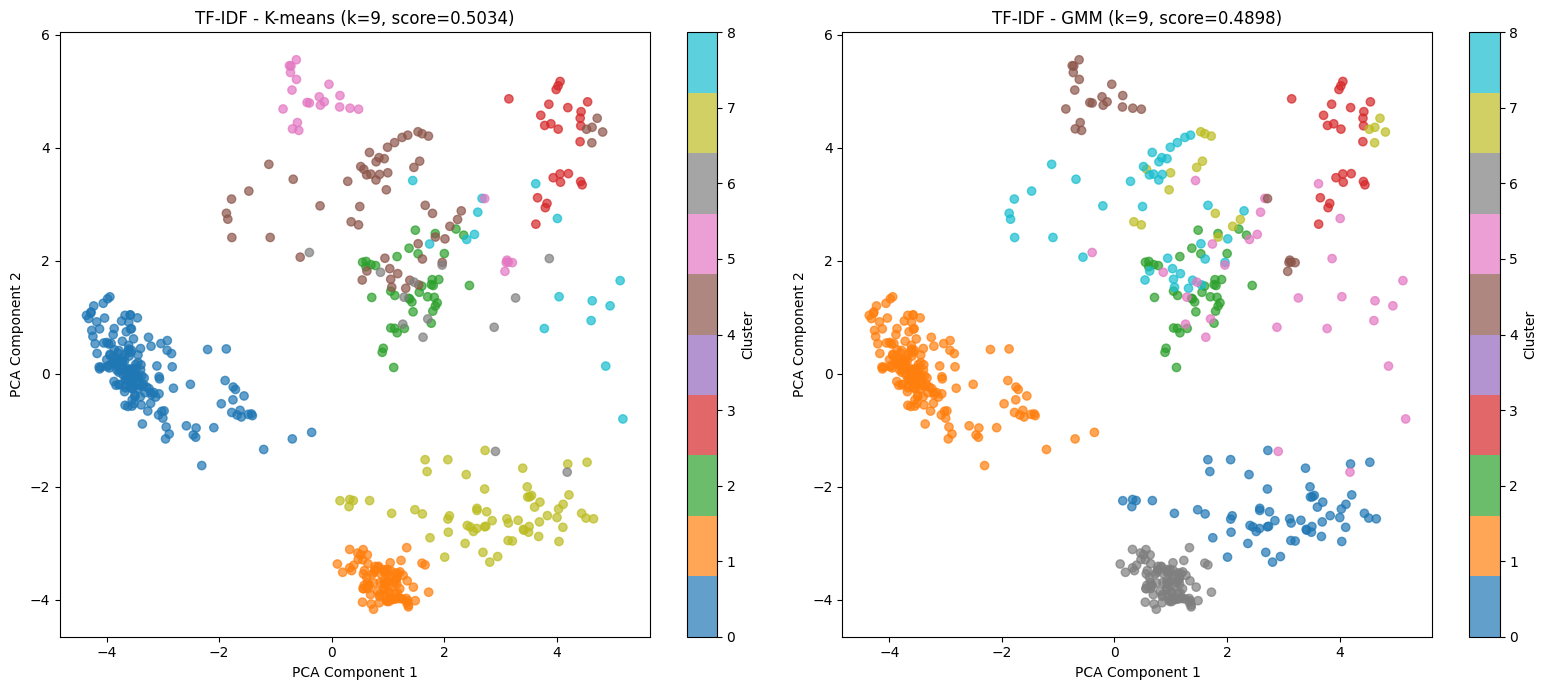

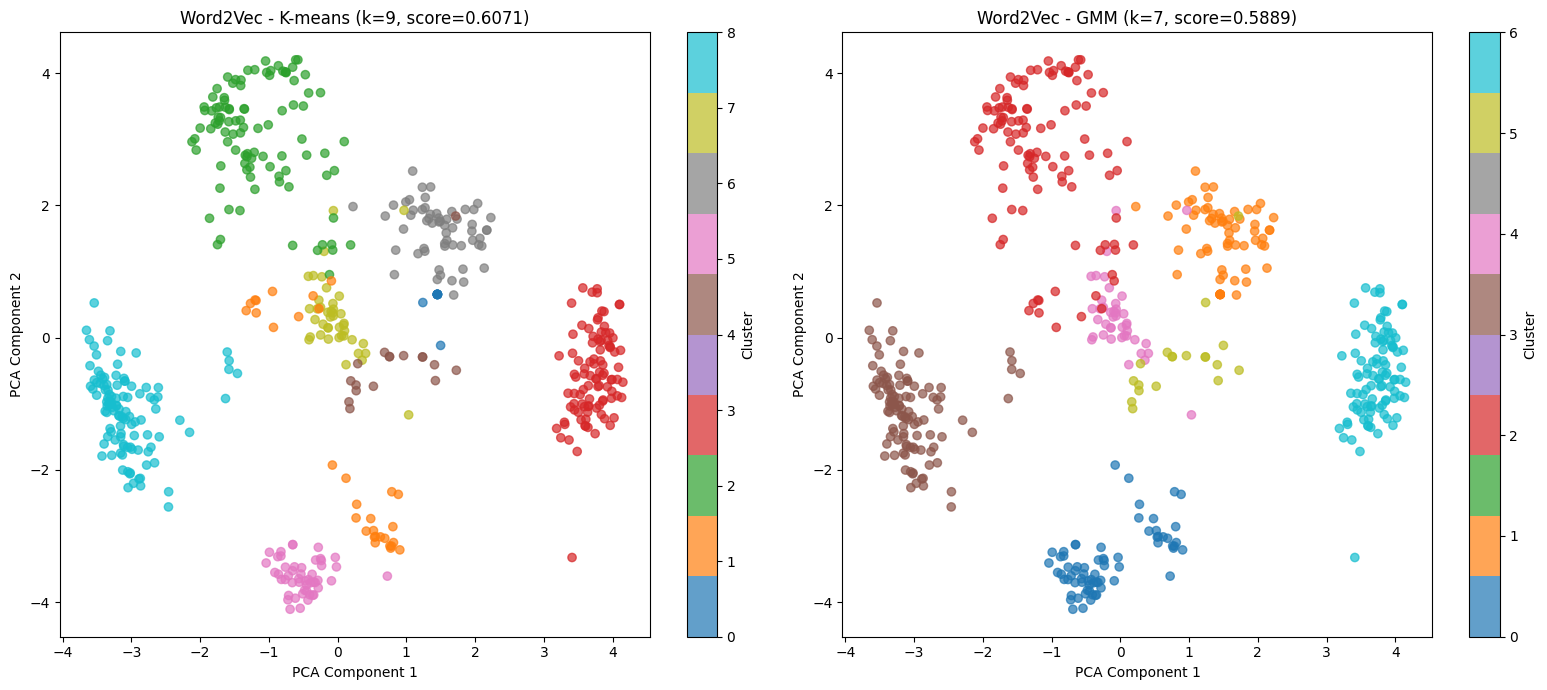

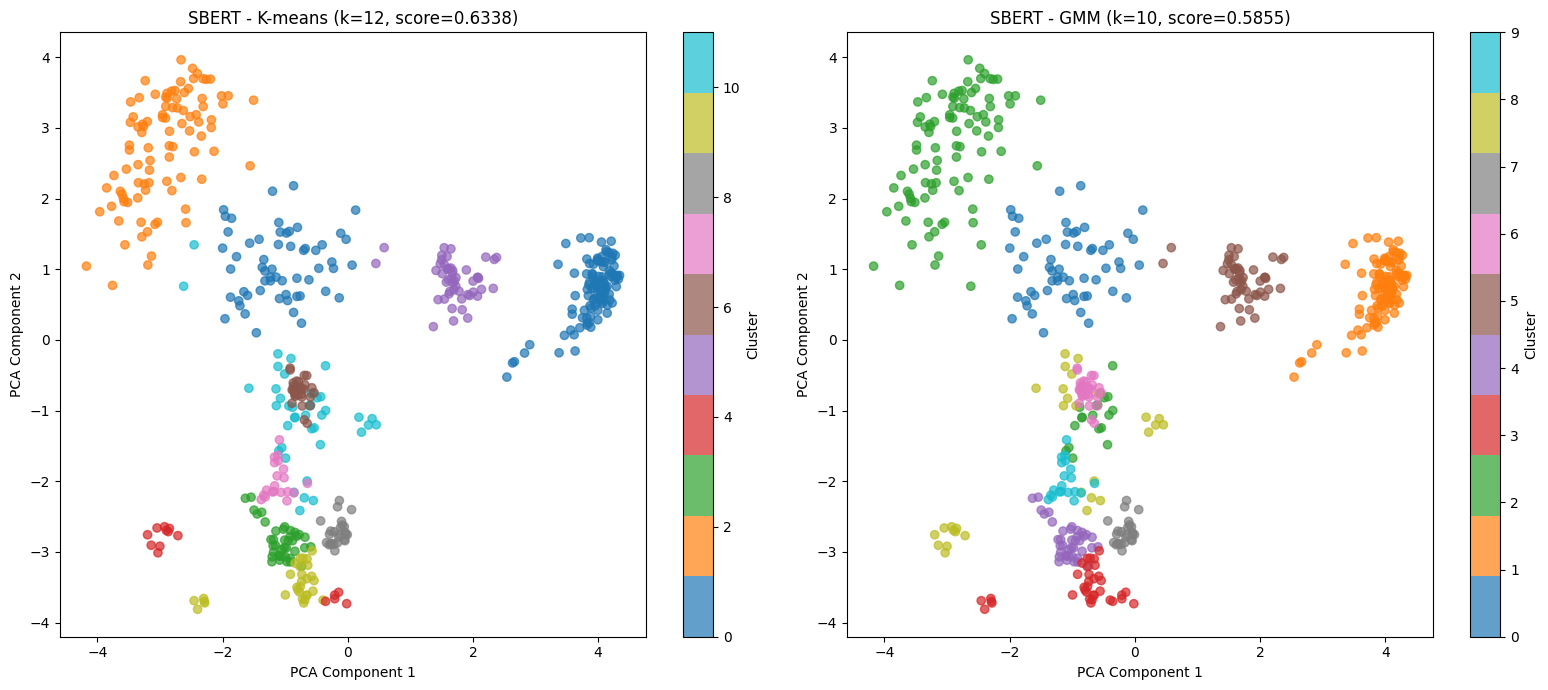

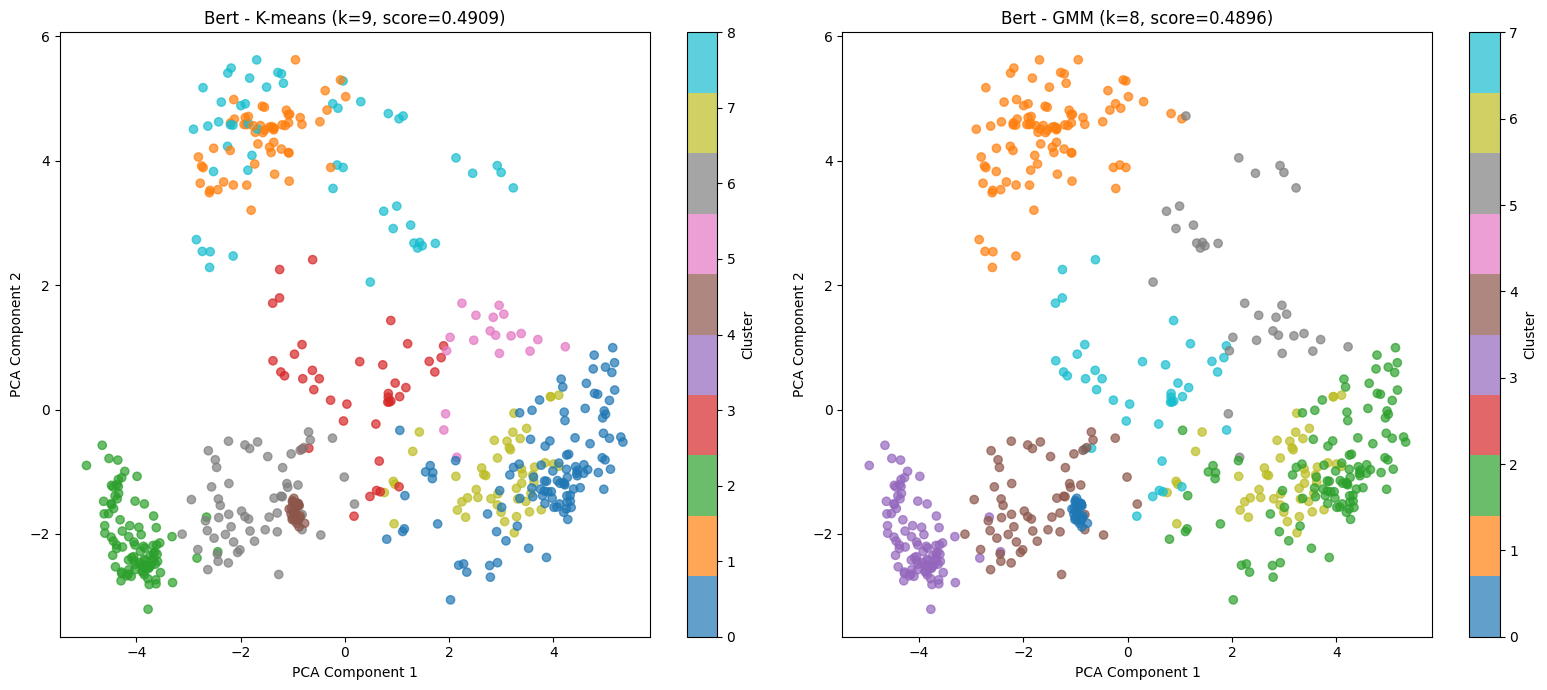

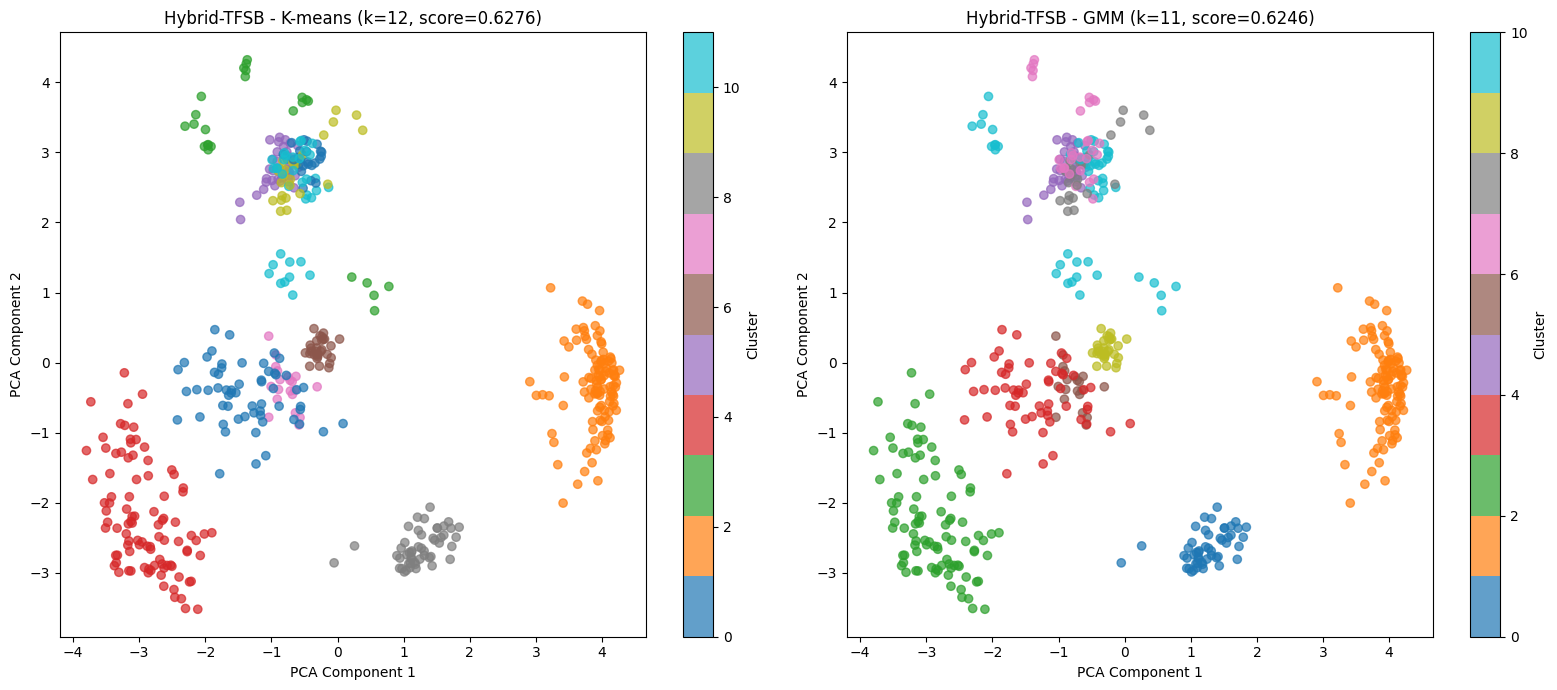

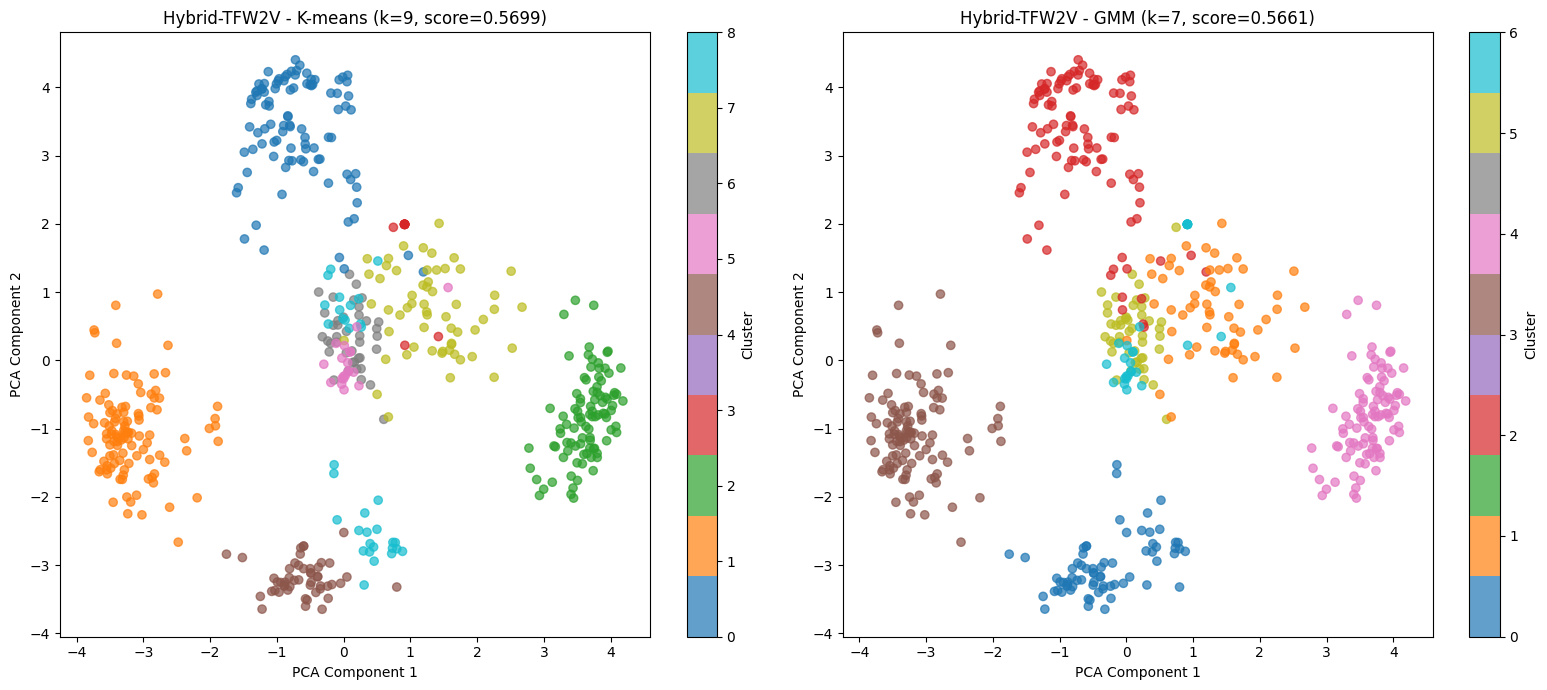

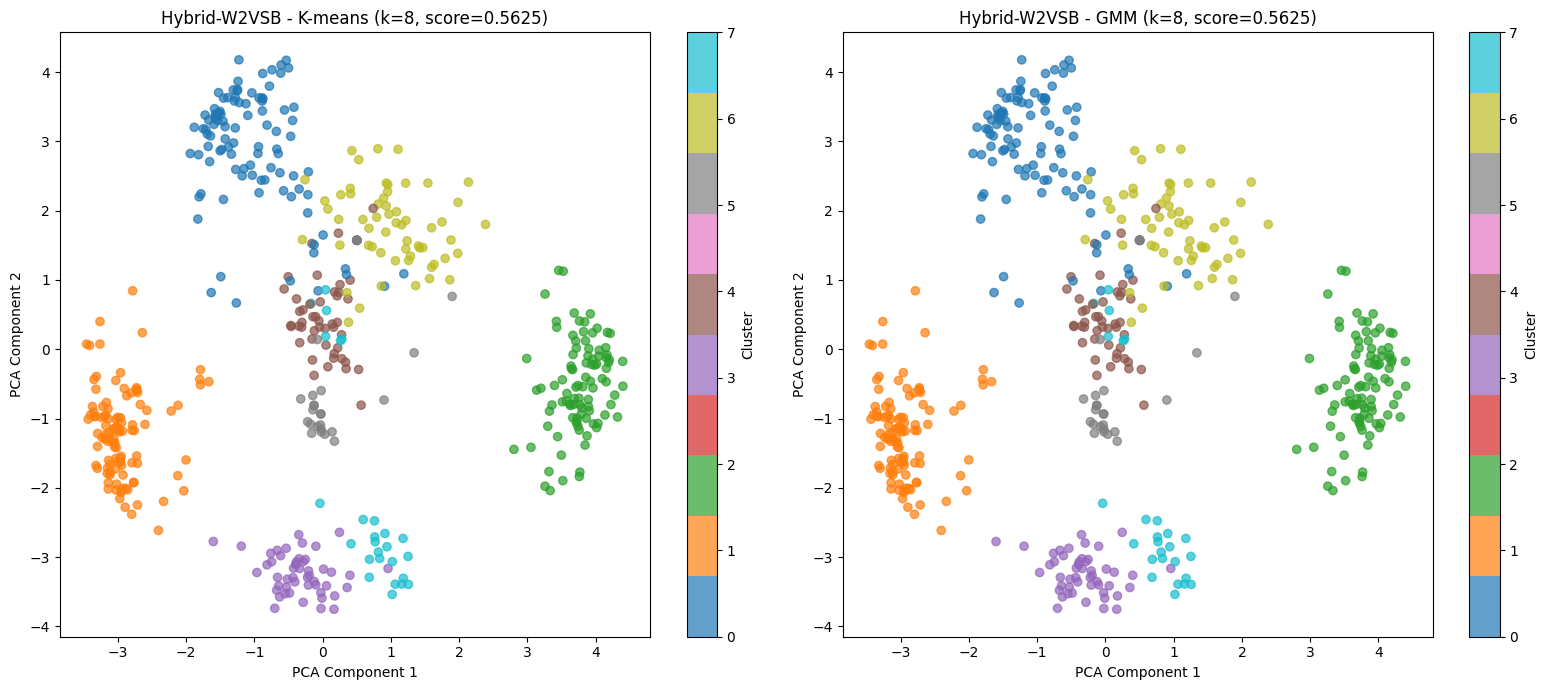

In [ ]:
# Generate scatter plots of the best clustering for each approach
for approach in approaches:
    if approach not in kmeans_results:
        continue

    # Path to the saved latent vectors and load them
    vectors_path = f"vae_{approach}/latent_vectors.npy"
    latent_vectors = np.load(vectors_path)

    # Apply PCA for visualization
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(latent_vectors)

    # Create a figure with two subplots side by side
    plt.figure(figsize=(16, 7))

    # K-means visualization
    plt.subplot(1, 2, 1)
    kmeans_labels = kmeans_results[approach]["labels"]
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.7)
    plt.title(f'{approach} - K-means (k={kmeans_results[approach]["best_k"]}, score={kmeans_results[approach]["best_score"]:.4f})')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Cluster')

    # GMM visualization
    plt.subplot(1, 2, 2)
    gmm_labels = gmm_results[approach]["labels"]
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=gmm_labels, cmap='tab10', alpha=0.7)
    plt.title(f'{approach} - GMM (k={gmm_results[approach]["best_k"]}, score={gmm_results[approach]["best_score"]:.4f})')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Cluster')

    plt.tight_layout()
    plt.show()


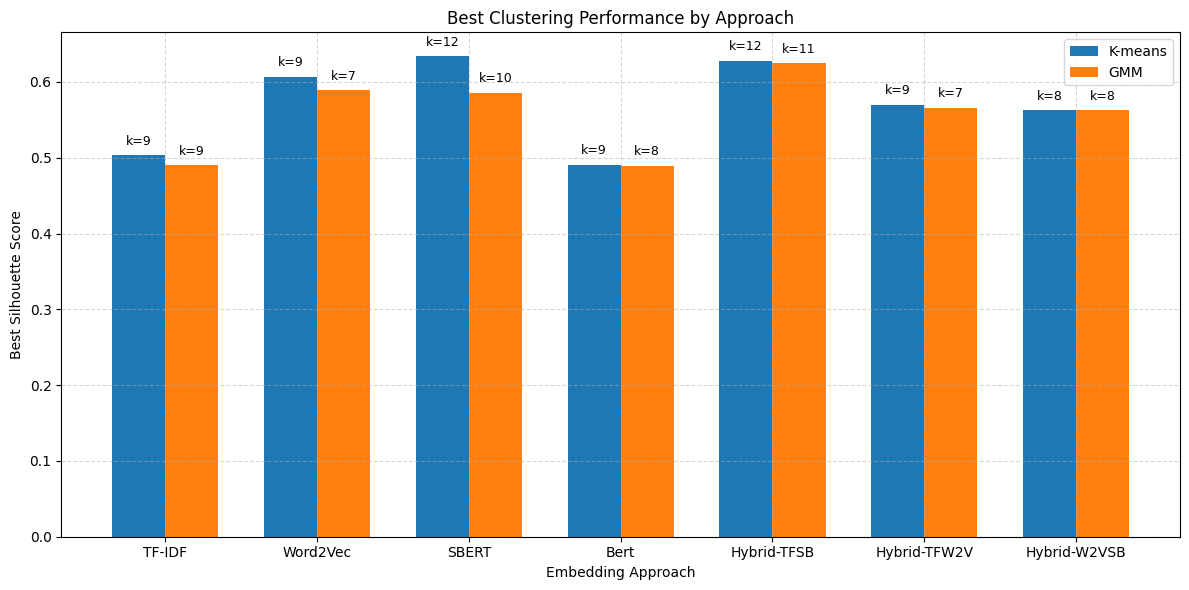


Summary of Best Results:
--------------------------------------------------------------------------------
Approach        | K-means Best k  | K-means Score   | GMM Best k      | GMM Score      
--------------------------------------------------------------------------------
TF-IDF          | 9               | 0.5034          | 9               | 0.4898
Word2Vec        | 9               | 0.6071          | 7               | 0.5889
SBERT           | 12              | 0.6338          | 10              | 0.5855
Bert            | 9               | 0.4909          | 8               | 0.4896
Hybrid-TFSB     | 12              | 0.6276          | 11              | 0.6246
Hybrid-TFW2V    | 9               | 0.5699          | 7               | 0.5661
Hybrid-W2VSB    | 8               | 0.5625          | 8               | 0.5625
--------------------------------------------------------------------------------


In [ ]:
# Final comparison of best scores across all approaches
approaches_found = [a for a in approaches if a in kmeans_results]


plt.figure(figsize=(12, 6))
x = np.arange(len(approaches_found))
width = 0.35

kmeans_best_scores = [kmeans_results[a]["best_score"] for a in approaches_found]
gmm_best_scores = [gmm_results[a]["best_score"] for a in approaches_found]

plt.bar(x - width/2, kmeans_best_scores, width, label='K-means')
plt.bar(x + width/2, gmm_best_scores, width, label='GMM')

plt.xlabel('Embedding Approach')
plt.ylabel('Best Silhouette Score')
plt.title('Best Clustering Performance by Approach')
plt.xticks(x, approaches_found)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

for i, v in enumerate(kmeans_best_scores):
    plt.text(i - width/2, v + 0.01, f'k={kmeans_results[approaches_found[i]]["best_k"]}',
             ha='center', va='bottom', fontsize=9)

for i, v in enumerate(gmm_best_scores):
    plt.text(i + width/2, v + 0.01, f'k={gmm_results[approaches_found[i]]["best_k"]}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('best_scores_comparison.png')
plt.show()

# Print the best results in a table format
print("\nSummary of Best Results:")
print("-" * 80)
print(f"{'Approach':<15} | {'K-means Best k':<15} | {'K-means Score':<15} | {'GMM Best k':<15} | {'GMM Score':<15}")
print("-" * 80)

for approach in approaches_found:
    kmeans_best_k = kmeans_results[approach]["best_k"]
    kmeans_score = kmeans_results[approach]["best_score"]
    gmm_best_k = gmm_results[approach]["best_k"]
    gmm_score = gmm_results[approach]["best_score"]

    print(f"{approach:<15} | {kmeans_best_k:<15} | {kmeans_score:.4f}{' '*9} | {gmm_best_k:<15} | {gmm_score:.4f}")

print("-" * 80)

**Conclusion**

Comparative Performance:
1. **SBERT** embeddings yielded the highest clustering quality overall, achieving a K-means score of 0.6338 at k = 12 clusters. This indicates that SBERT’s semantic-rich sentence embeddings are particularly effective at preserving meaningful structure even after the VAE transformation.
2. **Hybrid** approaches (e.g., Hybrid-TFSB, Hybrid-TFW2V, Hybrid-W2VSB) also performed very competitively:
    - **Hybrid-TFSB** (TF-IDF combined with SBERT) achieved the second-best K-means score at 0.6276 (k = 12) and a very high GMM score of 0.6246 (k = 11).
    - This suggests that fusing classical and semantic embeddings can enhance clustering performance by capturing both surface-level and deep semantic information.
3. Word2Vec alone performed moderately well with a K-means score of 0.6071 (k = 9) and GMM score of 0.5889 (k = 7), confirming that context-based embeddings are effective, but slightly less so compared to SBERT.
4. TF-IDF and BERT embeddings individually had lower clustering performance:
    - TF-IDF achieved a K-means score of 0.5034.
    - Raw BERT embeddings had the lowest K-means score of 0.4909 and GMM score of 0.4896.
    - This suggests that without fine-tuning or contextualization, traditional frequency-based models and base BERT embeddings might not be optimal for direct clustering after VAE.
5. GMM scores are generally lower than K-means scores across all embeddings, although the gap narrows for hybrid methods
    - This could indicate that K-means (which assumes spherical clusters) better matches the structure of the VAE-transformed latent space compared to GMM (which allows for elliptical clusters).

Broader Implications:
1. Semantic embeddings (SBERT, hybrids) retain structure better even after non-linear compression by VAE.
2. Combining surface-level (TF-IDF) and semantic features (SBERT/Word2Vec) results in more robust embeddings for clustering tasks.
3. Optimal cluster numbers typically ranged between 8–12, indicating moderate data complexity.

The overall pipeline—embedding compression via a LayerNorm-based VAE followed by clustering—proved to be a highly effective strategy for producing structured latent spaces conducive to meaningful clustering outcomes.